## Import models from Hugging Face hub
This sample shows how to import and register models from [HuggingFace hub](https://huggingface.co/models). 

### How does import work?
The import process runs as a job in your AzureML workspace using components from the `azureml` system registry. The models are downloaded and converted to MLflow packaged format. You can then register the models to your AzureML Workspace or Registry that makes them available for inference or fine tuning. 

### What models are supported for import?
Any model from Hugging Face hub can be downloaded using the `download_model` component. Only the following set of tasks are supported for MLflow conversion:
* fill-mask
* token-classification
* question-answering
* summarization
* text-generation
* text-classification
* translation
* image-classification
* text-to-image
Conversion to MLflow will fail if you attempt to download a model that has a task type other than the above.

### Why convert to MLflow?
MLflow is AzureML's recommended model packaging format. 
* **Inference benefits**: AzureML supports no-code-deployment for models packaged as MLflow that enables a seamless inference experience for the models. Learn more about [MLflow model packaging](https://learn.microsoft.com/en-us/azure/machine-learning/concept-mlflow-models) and [no-code-deployment](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-mlflow-models-online-endpoints?tabs=sdk). 
* **Fine tuning benefits**: Foundation models imported and converted to MLflow format can be fine tuned using AzureML's fine tuning pipelines. You can use the no-code UI wizards, or the code based job submission with the SDK or CLI/YAML. AzureML's fine tuning pipelines are built using components. This gives you the flexibility to compose your own fine tuning pipelines containing your own jobs for data transformation, post processing and the AzureML fine tuning components. Learn more about pipelines using [sdk](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipeline-python) or [CLI](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipelines-cli).

### What happens if I just download model and register models without converting to MLflow? That's because the task of the model I'm interested in is not among the supported list of tasks.
You can still download and register the model using the outputs of the `download_model` job. You need to [write your own inference code](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-online-endpoints?tabs=python) in this case. It also means that fine tuning is not yet supported if the task type of the model you are interested in is not in the supported list.

### Outline
* Setup pre-requisites such as compute.
* Pick a model to import.
* Configure the import job.
* Run the fine tuning job.
* Register the fine tuned model. 


**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription - [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace with computer cluster - [Configure workspace](../../configuration.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md) - check the getting started section


**Motivations** - This notebook explains how to create model importing/publishing pipeline job in workspace using pipeline component registered in registry

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1 Import the required libraries

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential, ClientSecretCredential
from azure.ai.ml import UserIdentityConfiguration

from azure.ai.ml import MLClient, Input, Output
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component

## 1.2 Configure credential

We are using `DefaultAzureCredential` to get access to workspace. 
`DefaultAzureCredential` should be capable of handling most Azure SDK authentication scenarios. 

Reference for more available credentials if it does not work for you: [configure credential example](../../configuration.ipynb), [azure-identity reference doc](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

In [2]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot.this issue.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: Azure Active Directory error '(invalid_grant) AADSTS700082: The refresh token has expired due to inactivity. The token was issued on 2022-11-30T10:35:15.8902256Z and was inactive for 90.00:00:00.
Trace ID: 308abe03-3734-4811-bdb5-1e59958f2e00
Correlation ID: d212ec21-840a-41ff-bd65-82f66bd45be5
Timestamp: 2023-04-01 05:34:18Z'
Content: {"error":"invalid_grant","error_description":"AADSTS700082: The refresh token has expired due to inactivity. The token was issued on 2022-11-30T10:35:15.8902256Z and was inactive for 

## 1.3 Get a handle to the workspace and the registry

We use config file to connect to a workspace. The Azure ML workspace should be configured with computer cluster. [Check this notebook for configure a workspace](../../configuration.ipynb)

In [3]:
# Get a handle to workspace
ml_client_ws = MLClient(
        credential,
        subscription_id =  "ed2cab61-14cc-4fb3-ac23-d72609214cfd",
        resource_group_name =  "training_rg",
        workspace_name =  "modelpublishing-eastus2"
)

ml_client_registry = MLClient(credential, registry_name="azureml-preview-test1")

# Retrieve an already attached Azure Machine Learning Compute.
cluster_name = "cpu-cluster"
print(ml_client_ws.compute.get(cluster_name))

enable_node_public_ip: true
id: /subscriptions/ed2cab61-14cc-4fb3-ac23-d72609214cfd/resourceGroups/training_rg/providers/Microsoft.MachineLearningServices/workspaces/modelpublishing-eastus2/computes/cpu-cluster
idle_time_before_scale_down: 120
location: eastus2
max_instances: 4
min_instances: 0
name: cpu-cluster
provisioning_state: Succeeded
size: STANDARD_DS3_V2
ssh_public_access_enabled: false
tier: dedicated
type: amlcompute



# 2. Load piepeline component from registry to create pipeline


## 2.1 Use registery handle to load the components in workspace

### Components
- import_model - Pipeline component which downloads the model, convert it into mlflow, validate locally and then register respectively

In [4]:
import_model = ml_client_registry.components.get(
    name="import_model", version="0.1.0"
)

# 3. Create a pipeline job using pipeline component

## 3.1 Create pipeline object using necessary parameters


#### Necessary parameters to pass
- model_id                                
- compute - Compute cluster on which pipeline job will run

#### model_id can be found from the hugging face repository, when we go to the models section in HF repostitory , and select any model this page will come up

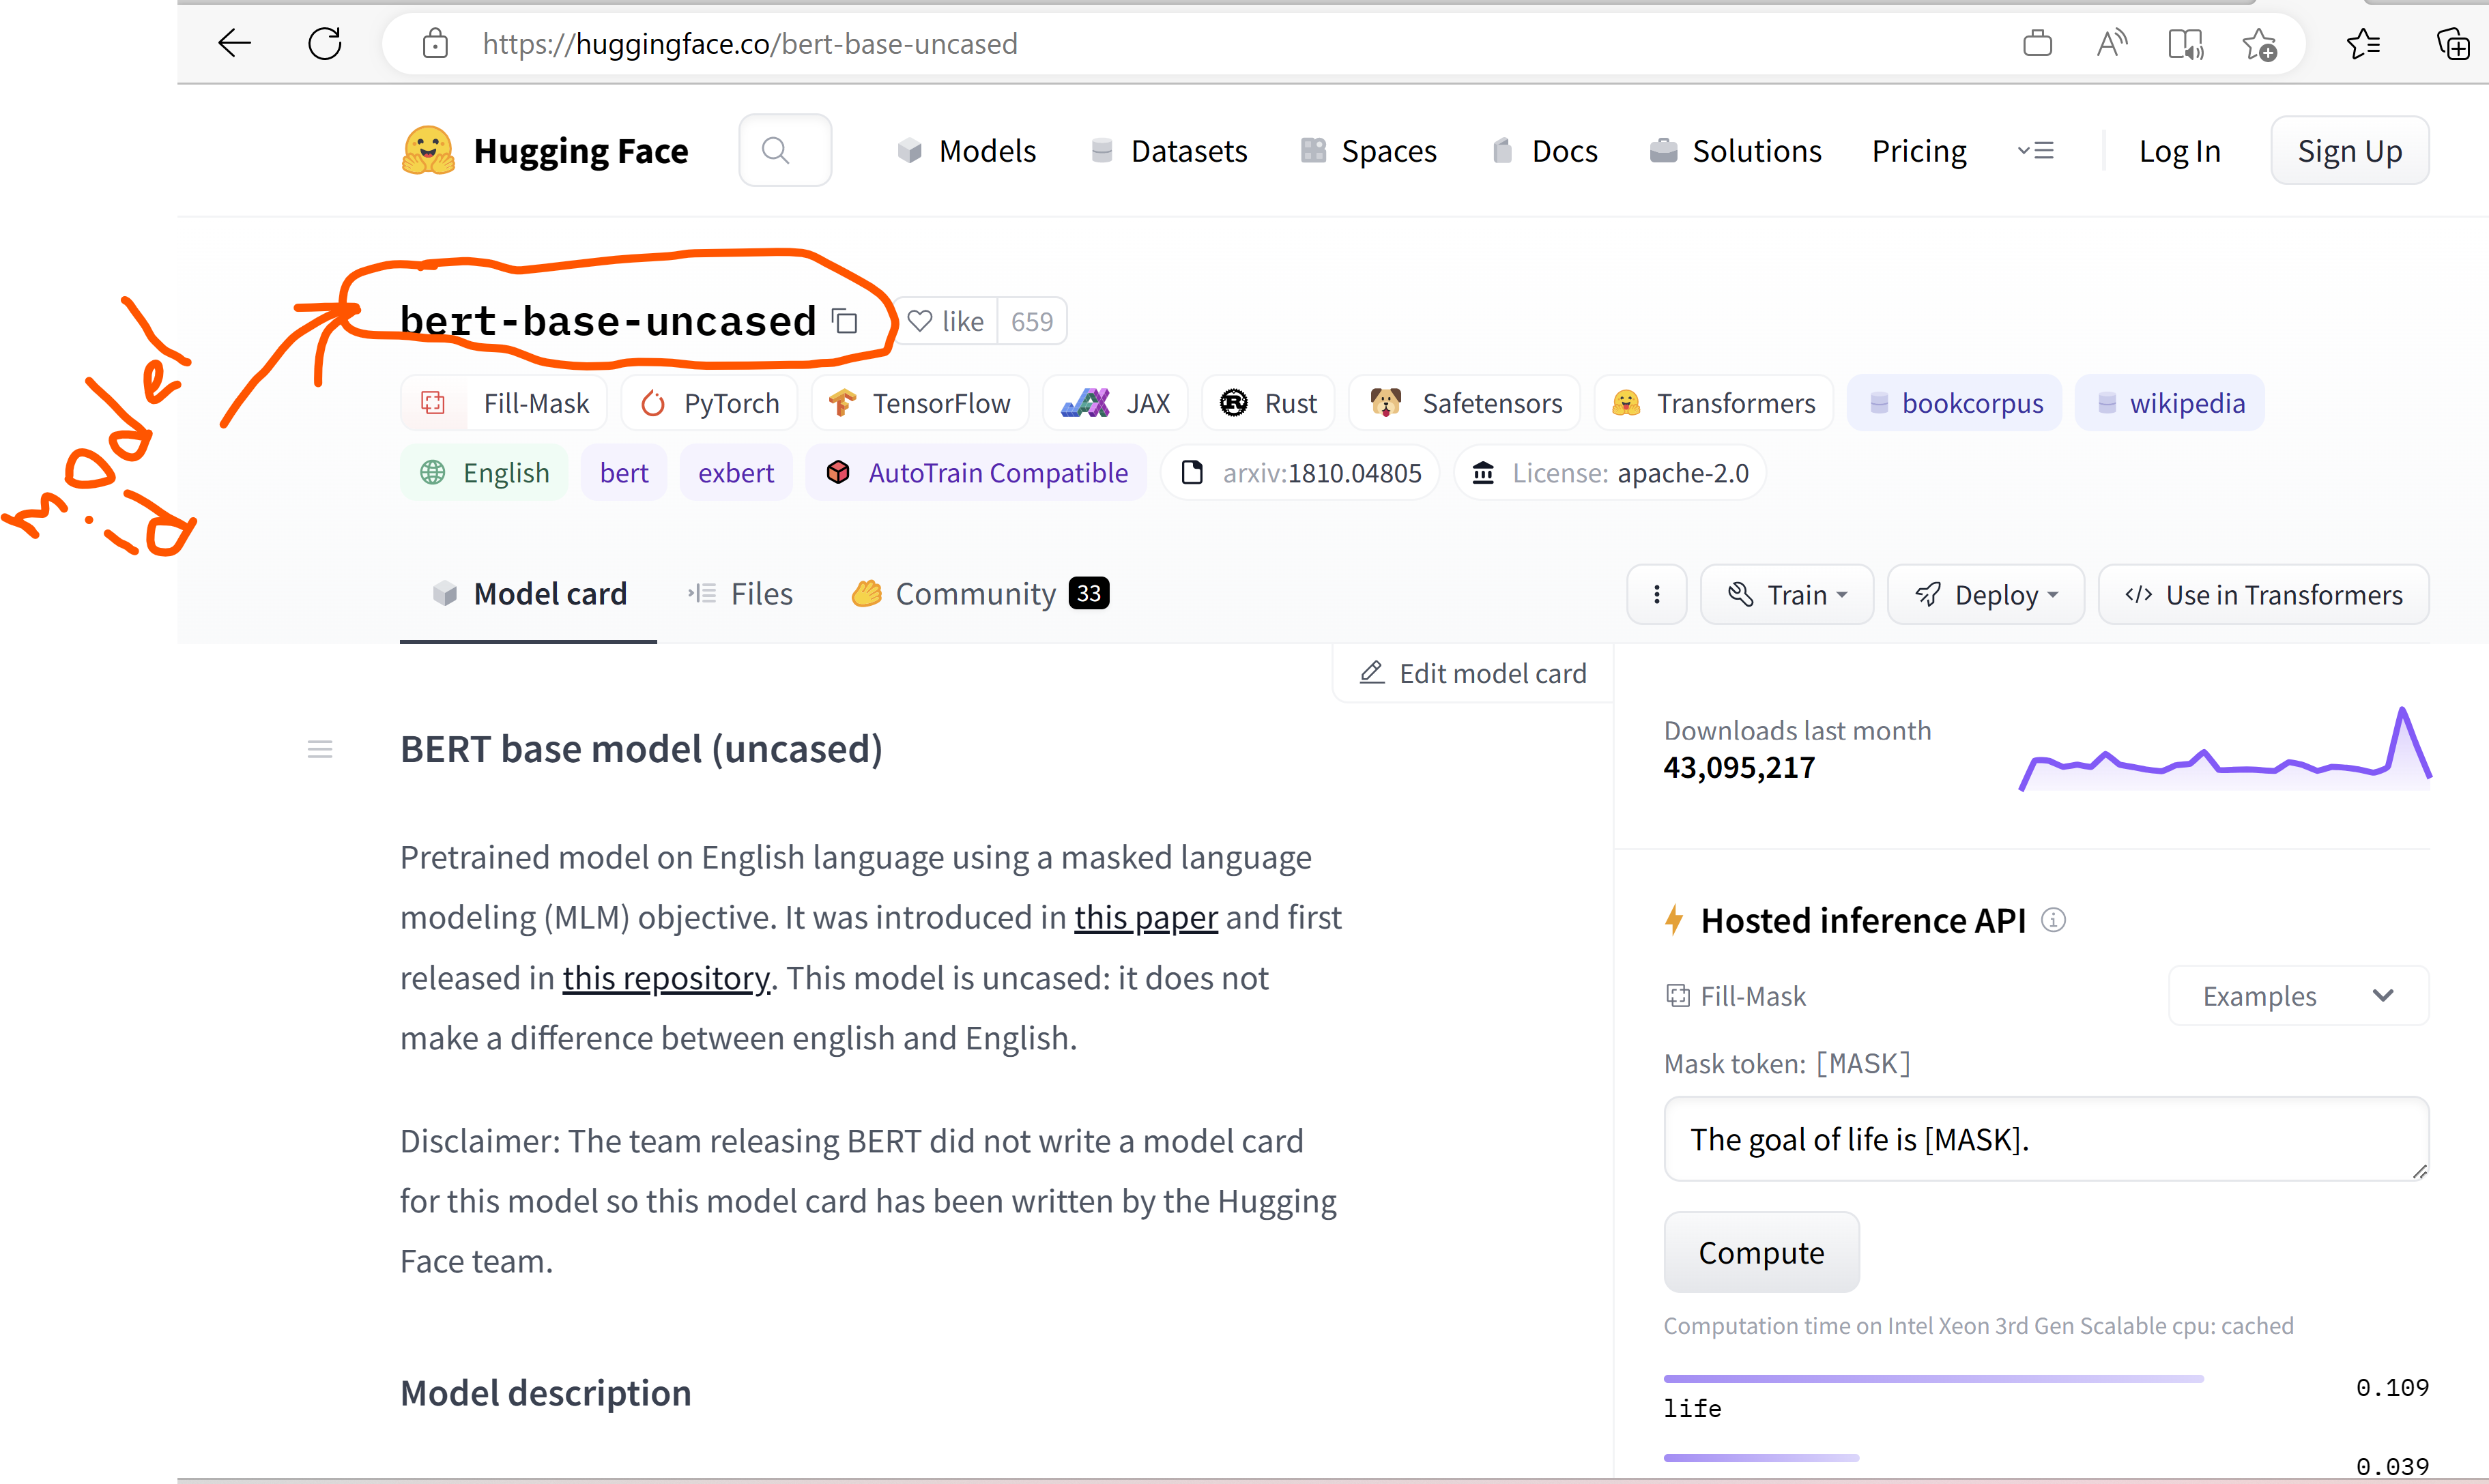

In [5]:
pipeline_object = import_model(
                    model_id = "bert-base-uncased",
                    compute = cluster_name
                    # registry_name = "azureml-preview-test1", pass only if you want to register model in registry
                    )

## 3.2 Setting pipeline computes,identity 

In [6]:
# Settings of compute and Identity
pipeline_object.settings.force_rerun = True
pipeline_object.settings.default_compute  = cluster_name
pipeline_object.identity = UserIdentityConfiguration()

# 4. Submit the import job


In [7]:
# submit the pipeline job
pipeline_job = ml_client_ws.jobs.create_or_update(pipeline_object, experiment_name=f"bert-base-uncased import")
# wait for the pipeline job to complete
ml_client_ws.jobs.stream(pipeline_job.name)

RunId: coral_kitchen_0znhfbx1b8
Web View: https://ml.azure.com/runs/coral_kitchen_0znhfbx1b8?wsid=/subscriptions/ed2cab61-14cc-4fb3-ac23-d72609214cfd/resourcegroups/training_rg/workspaces/modelpublishing-eastus2

Streaming logs/azureml/executionlogs.txt

[2023-04-01 05:35:13Z] Submitting 1 runs, first five are: 0ecb7fef:046beda1-affa-4972-b81e-1e2a38de1465
[2023-04-01 05:43:22Z] Completing processing run id 046beda1-affa-4972-b81e-1e2a38de1465.
[2023-04-01 05:43:22Z] Submitting 1 runs, first five are: 48a719d1:55146b79-8802-47cb-8314-1f3ba14d3c21
[2023-04-01 05:44:16Z] Execution of experiment failed, update experiment status and cancel running nodes.

Execution Summary
RunId: coral_kitchen_0znhfbx1b8
Web View: https://ml.azure.com/runs/coral_kitchen_0znhfbx1b8?wsid=/subscriptions/ed2cab61-14cc-4fb3-ac23-d72609214cfd/resourcegroups/training_rg/workspaces/modelpublishing-eastus2


JobException: Exception : 
 {
    "error": {
        "code": "UserError",
        "message": "Pipeline has failed child jobs. Failed nodes: /mlflow_convert_model. For more details and logs, please go to the job detail page and check the child jobs.",
        "message_format": "Pipeline has failed child jobs. {0}",
        "message_parameters": {},
        "reference_code": "PipelineHasStepJobFailed",
        "details": []
    },
    "environment": "eastus2",
    "location": "eastus2",
    "time": "2023-04-01T05:44:16.181884Z",
    "component_name": ""
} 